In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names-shuffled.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {c:i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k, v in stoi.items()}
vocab_size = len(itos)
print(vocab_size)

27


In [4]:
# change the context length to 8
context_length = 8 # context length: number of chars used to predict the next char

def build_dataset(words):
    X, Y = [], [] # inputs and labels

    for w in words:
        context = [0] * context_length
        for c in w + '.':
            X.append(context)
            Y.append(stoi[c])
            context = context[1:] + [stoi[c]] # sliding the context by 1 character to right

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])      # 10%

torch.Size([404420, 8]) torch.Size([404420])
torch.Size([50599, 8]) torch.Size([50599])
torch.Size([50438, 8]) torch.Size([50438])


In [5]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join([itos[c.item()] for c in x]), "-->", itos[y.item()])

........ --> u
.......u --> p
......up --> j
.....upj --> e
....upje --> e
...upjee --> t
..upjeet --> h
.upjeeth --> .
........ --> r
.......r --> e
......re --> e
.....ree --> h
....reeh --> a
...reeha --> .
........ --> n
.......n --> i
......ni --> r
.....nir --> a
....nira --> n
...niran --> i


In [6]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5 # kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.eps = eps
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x: torch.Tensor):

        # during training calculate the batch statistics
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        # while inference use running statistics
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xnorm = (x - xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xnorm + self.beta

        # during training calculate the running statistics
        # during inference these are fixed
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var  = (1-self.momentum)*self.running_var  + self.momentum*xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
# ---------- new classes ----------

class Embedding: # equivalent to emb = C[Xb]
    def __init__(self, vocab_size, n_emb_dim):
        self.weight = torch.randn((vocab_size, n_emb_dim))
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
    
class Flatten: # equivalent to x = emb.view(-1, context_length*n_emb_dim) # 24x30
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [7]:
torch.manual_seed(42);

In [8]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

# C = torch.randn((vocab_size, n_emb_dim)) # moved to model class as Embedding layer

model = Sequential([
     # moving the emb = C[Xb] and x = emb.view(-1, context_length*n_emb_dim) code here so that we don't have to do it manually in training loop
    Embedding(vocab_size, n_emb_dim), Flatten(),
    Linear(context_length*n_emb_dim, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # as we've BN now, we won't be changing the weights of the last layer but we'll be changing the gamma
    # gamma is multiplied with the weights in BN
    model.layers[-1].weight *= 0.1
    # layers[-1].gamma *= 0.1

    # # all other layers: apply gain
    # for layer in layers[:-1]:
    #     if isinstance(layer, Linear):
    #         layer.weight *= 1.0 # 5/3 # not required with BN

# parameters = [C] + [p for layer in layers for p in layer.parameters()]

# embedding parameters now come from the Embedding layer
parameters = model.parameters()


print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [9]:
epochs = 200000
batch_size = 24
lossi = []

for i in range(epochs):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    # this has been moved to the model above
    # emb = C[Xb] # 24x3x10
    # x = emb.view(-1, context_length*n_emb_dim) # 24x30

    # x = Xb
    # for layer in layers:
    #     x = layer(x)

    # moved the above code to the Squential class

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)


    # zero grads
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()

    # update weights
    lr = 0.1 if i < 150000 else 0.01 # updated lr after introducing the BN
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3028


We have changed the context length from 3 to 8. But this network doesn't make much sense as we're crushing way too much information way too fast.

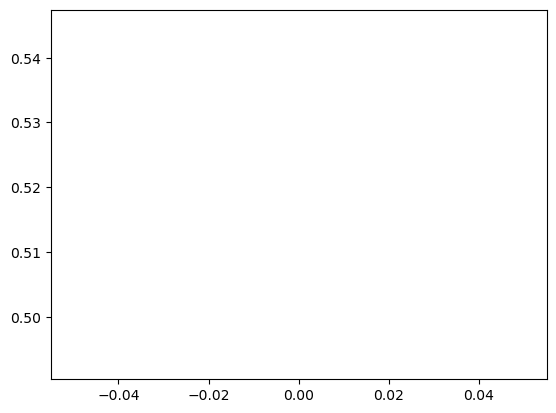

In [10]:
plt.plot(lossi);

### Smoothen the curve

In [11]:
# lossi is of shape [200000]. We converted it to shape [200, 1000] and then took the mean of each row
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1));
# in the plot, there's a decay at 150 it is because of the change in learning rate in the training loop

RuntimeError: shape '[-1, 1000]' is invalid for input of size 1

In [12]:
# put layers into eval mode (needed for BN)
for layer in model.layers:
    layer.training = False

In [13]:
@torch.no_grad() # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 3.2523512840270996
dev 3.251798152923584


#### Performance Log

- Original (3 character context + 200 hidden neurons + 12K params): train = 1.91, val = 1.92
- context: 3 -> 8 (22K params): train = 1.79, val = 1.82

In [14]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * context_length

    while True:

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[c] for c in out]))

mscrarfpwejsozurbhpvgps.
yvxiarf.
nqvpgy.
xjscmczipgdoglxpfvmnexheopeymotjkjwtvhhurrhqbqgvznkmhhkocxfizeooxgwtebfwzdn.
koefwsgkvrokzhosrweymlidxi.
sdyotwgnczk.
edejbxkxwxgbaepnkhcyplbvdanfritnikkkgpiikqpqfasw.
irsywjhzwupxychgr.
jqjraqruemasxegkoalumorjngapshlhapxqthbvaspwpuizqsquglcaa.
ghhwlo.
urahsaesprvfopglemqwvzcgffjfxjonhukcdairhkeznzmkbxa.
kalrcpsfeh.
dxamefcpgpqeuxijxjpqqkykqldwpnxmforwtcrhnqckekm.
tqljiakqdujeay.
xatkqwwkwflqvatmvkedgwbepek.
fkkzjbifjpvnanzskyaftdo.
yjlzwjtdivvg.
kygazlsvmyhhfmqoqnudrzoeyuxvnfaojofjtdvdd.
oaruvaliklnp.
zlys.


### Wavenet

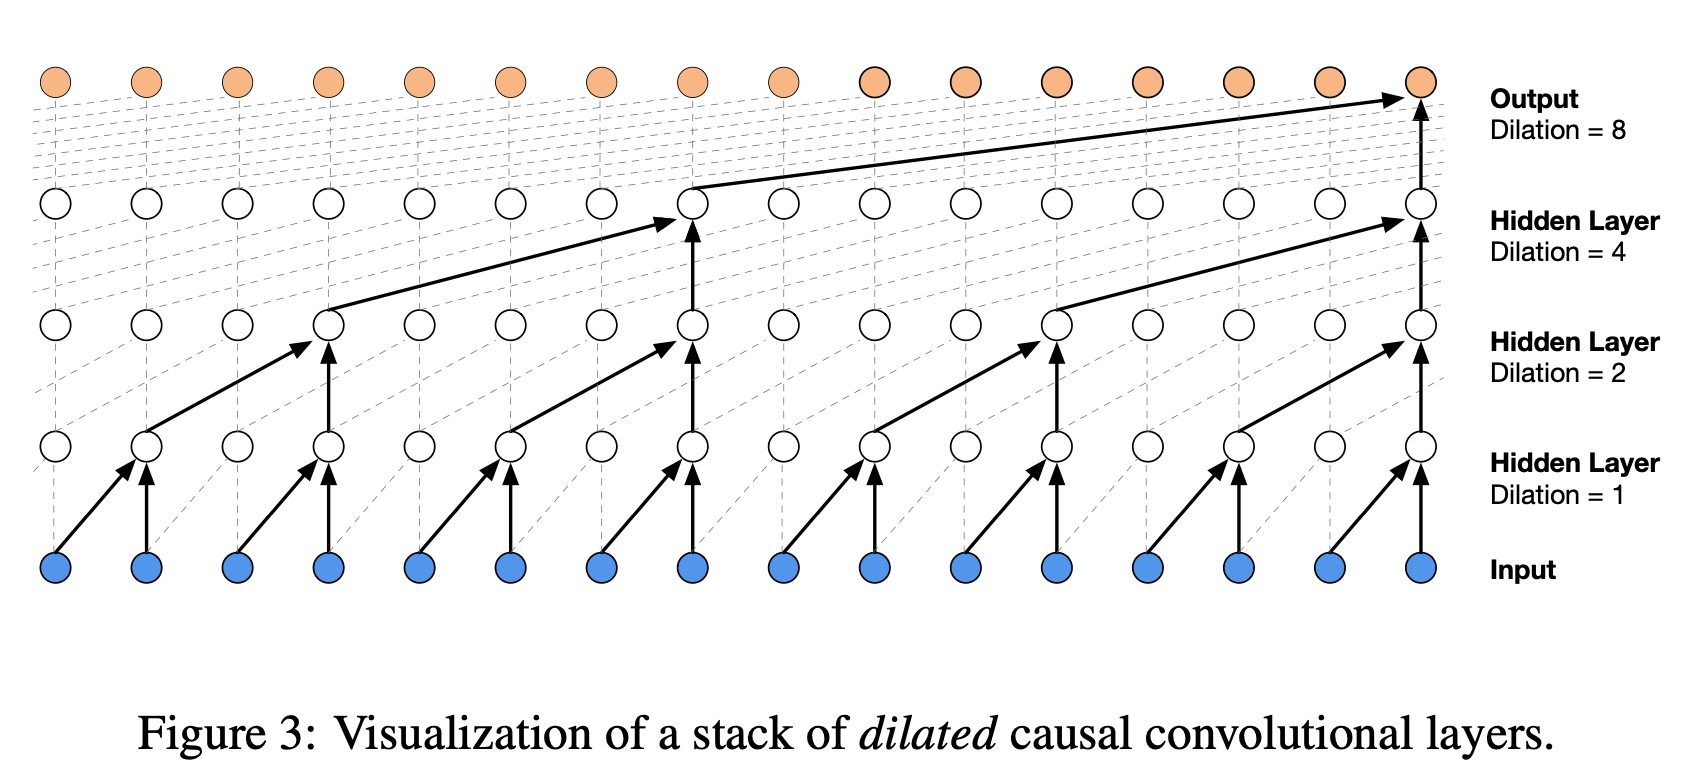

We will try to club the inputs as in above diagram of Wavenet. In each layer 2 inputs are clubbed into 1.

Let's first examine the shape of each layer.

In [15]:
ix = torch.randint(0, Xtr.shape[0], (4, )) # let's take a look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(logits.shape)
print(Xb.shape)

Xb


torch.Size([4, 27])
torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 19,  1],
        [ 0,  0, 21, 19,  9, 20,  8,  1],
        [ 0,  0, 19, 21, 18, 25,  1, 14],
        [ 0,  0,  0,  0,  0,  1, 13, 15]])

In [16]:
model.layers[0].out.shape # output of Embedding layer

# Embedding layer takes out an embedding of size 10 for each character. Hence the output size is 4x8x10.
# Each character is represented by 10 integers.

torch.Size([4, 8, 10])

In [17]:
model.layers[1].out.shape # output of Flatten layer

# The flatten layer concatenates all the embeddings of each charater in an example in one row.
# In each of the 4 examples, there are 8 characters and each character has an embedding of size 10.
# So flatten will convert the 4x8x10 into 4x80, bringing all the embeddings for an example in one row.

torch.Size([4, 80])

In [18]:
model.layers[2].out.shape # output of 1st Linear layer

torch.Size([4, 200])

In [20]:
# In linear layer, input @ weights + bias

((torch.randn(4, 80)@torch.randn(80, 200))+ torch.randn(200)).shape

torch.Size([4, 200])

In [21]:
# Let's look at torch's matrix multiplication
print((torch.randn(4, 80)@torch.randn(80, 200)).shape) # --> results in 4, 200

# we can add more dimensions to input matrix and it'd still work. Torch just looks at the last dimension.
print((torch.randn(4, 5, 6, 80)@torch.randn(80, 200)).shape) # --> results in 4, 5, 6, 200

# Imagine a 3D block that is 4 blocks tall, each containing 5 rows, with each row containing 6 channels. 
# Inside each channel, you have a vector of 80 values.
# After multiplication: Each 80-dimensional vector in this 3D block has been stretched into a 200-dimensional vector.

torch.Size([4, 200])
torch.Size([4, 5, 6, 200])


All the dimensions on the left are treated as "batch dimensions" and in parallel over all those dimensions, we're doing
the matrix multiplication on the last dimension.

This can be used in our wavenet now.

We've these 8 characters coming in:

1 2 3 4 5 6 7 8

We don't want to flatten out all the embeddings of all these characters (as is being done in the flatten layer). Instead we want to group these like (as per wavenet diagram above):

(1 2) (3 4) (5 6) (7 8)

So, each of the 2 consecutive elements' embedding should be flattened out and multiplied with the weight matrix. All of thse 4 groups here we want to process in parallel. So this is kinda "batch dimension" we wanna introduce.

In [23]:
# effectively, we want to change from:
print((torch.randn(4, 80)@torch.randn(80, 200)).shape)

# to:

print((torch.randn(4, 4, 20)@torch.randn(20, 200)).shape)

# so 4 examples with 4 groups of 2 elements with each having embeddings of length 10

torch.Size([4, 200])
torch.Size([4, 4, 200])


So now we want to modify the flatten layer so that every 2 consecutive characters are packed in the last dimension. The flatten layer now will not fully flatten out the entire example, it needs to create [4, 4, 20] instead of [4, 80].

We also need to modify the linear layer in terms of how many inputs it should expect. It should't expect 80, rather it shoult now expect 20.

In [26]:
# currently the flatten layer gets the input of size [4, 8, 10]

e = torch.randn(4, 8, 10)

# and converts to [4, 80]
print(e.view(4, -1).shape)

# instead we want [4, 4, 20], where consecutive embeddings of length 10 get concatenated
print(e.view(4, -1, 20).shape)
# (-1) view will automatically calculate how many groups it needs to create packs of size 20

torch.Size([4, 80])
torch.Size([4, 4, 20])


In [27]:
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n # number of consecutive elements we want to concatenate in the last dimension
    def __call__(self, x):
        # in our example above, B=4, T=8, C=10
        B, T, C = x.shape

        # self.out = x.view(x.shape[0], -1) --> previously

        # updated
        x = x.view(B, T // self.n, C * self.n) #  as per example above, T // n => 8//2 and C * self.n => 10*2

        # if after view, the second dimension, i.e. T // self.n is 1, we want to remove and just have [B, C*self.n]
        # it will be similar to what we were doing previously i.e. x.view(x.shape[0], -1)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        
        self.out = x

        return self.out
    def parameters(self):
        return []

Let's test this class now!

In [28]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

model = Sequential([
    Embedding(vocab_size, n_emb_dim), 
    # context_length = 8. With 8, it should work as previouly, we're concatenating all the 8 characters.
    FlattenConsecutive(context_length),
    Linear(context_length*n_emb_dim, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [30]:
ix = torch.randint(0, Xtr.shape[0], (4, )) # let's take a look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(logits.shape)
print(Xb.shape)

Xb

torch.Size([4, 27])
torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 10,  1, 20,  8],
        [14,  9, 12,  1,  1, 20,  8,  1],
        [ 0,  0,  0,  0,  0,  0, 19, 21],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [31]:
for layer in model.layers:
    print(layer.__class__.__name__, ': ', tuple(layer.out.shape))

Embedding :  (4, 8, 10)
FlattenConsecutive :  (4, 80)
Linear :  (4, 200)
BatchNorm1D :  (4, 200)
Tanh :  (4, 200)
Linear :  (4, 27)


FlattenConsecutive is  (4, 80). It means it working fine, working as previous flatten layer.

Now implementing hierarchical structure of wavenet

In [32]:
n_emb_dim = 10    # embedding dimensionality
n_hidden = 200    # neurons in hidden layers

model = Sequential([
    Embedding(vocab_size, n_emb_dim),

    FlattenConsecutive(2),
    Linear(2*n_emb_dim, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),

    FlattenConsecutive(2),
    # after applying the flatten on the output of first linear layer, the last dimension will become 2*n_hidden, hence
    # the first dimension of following linear layers are 2*n_hidden. See the layer.out.shape below for explanation.
    Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),

    FlattenConsecutive(2),
    Linear(2*n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),

    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [33]:
ix = torch.randint(0, Xtr.shape[0], (4, )) # let's take a look at a batch of 4 examples
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(logits.shape)
print(Xb.shape)

Xb

torch.Size([4, 27])
torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 18,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  1,  2,  9, 14,  5],
        [ 0,  0,  0, 13,  9, 18, 20,  8]])

In [34]:
for layer in model.layers:
    print(layer.__class__.__name__, ': ', tuple(layer.out.shape))

Embedding :  (4, 8, 10)
FlattenConsecutive :  (4, 4, 20)
Linear :  (4, 4, 200)
BatchNorm1D :  (4, 4, 200)
Tanh :  (4, 4, 200)
FlattenConsecutive :  (4, 2, 400)
Linear :  (4, 2, 200)
BatchNorm1D :  (4, 2, 200)
Tanh :  (4, 2, 200)
FlattenConsecutive :  (4, 400)
Linear :  (4, 200)
BatchNorm1D :  (4, 200)
Tanh :  (4, 200)
Linear :  (4, 27)


We can see above that in the last FlattenConsecutive :  (4, 400), it has squeezed out the dimension of 1.

Now we've implemented the hierarchical structure of wavenet.